## Mapping Chicago's 2020 E-Scooter Pilot

### Background
On August 12, the Chicago Department of Transportation (CDOT) and the Department of Business Affairs and Consumer Protection (BACP) launched a second, four-month electric-scooter pilot program that "includes enhanced requirements to keep sidewalks and the right of way clear of obstructions, and ensures equitable distribution of scooters throughout the City." This second pilot includes 10,000 scooters divided equally among three vendors: Bird, Lime and Spin. 

"The second pilot requires the vendors to deploy at least half their fleets in Priority Areas that cover 43% of the total pilot area. The equity priority areas cover neighborhoods where residents face systemic disadvantages following generations of underinvestment and inequitable access to transportation and other resources. Compliance to this requirement will be checked twice per day. Vendors will provide the City with real-time data on operations, ridership, and safety, and the City may suspend or revoke the licenses of vendors that fail to adhere to the pilot’s terms."

Read the full press release [here](https://www.chicago.gov/city/en/depts/cdot/provdrs/bike/news/2020/august/city-of-chicago-launches-2020-shared-e-scooter-pilot-program-wit.html).

### Analysis
This Jupyter Notebook maps Bird and Lime fleets to visualize where the scooters are and if they comply with having half their fleets in Priority Areas, shown on [this map](https://www.chicago.gov/content/dam/city/depts/cdot/Misc/EScooters/2020/Chicago%202020%20E-Scooter%20Pilot%20Map.pdf). 

### Next Steps
In order to fully examine vendor compliance, I will need access to shapefiles representing:
- Pilot Area
- Equity Priority Area
- Exclusion Area

In [1]:
import json
import os
import boto3

from dotenv import load_dotenv
load_dotenv()

import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import pandas as pd
import numpy as np

from time import ctime

from boto3 import session
from botocore.exceptions import ClientError

In [2]:
client = boto3.client(
    "s3",
    aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID"),
    aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY"),
)

In [3]:
# Prefix can also be created with datetime.strftime
snapshots = {}
providers = ['lime','bird']

for org in providers:
    i = 0
    if org not in snapshots:
        snapshots[org] = []
        
    for snapshot in client.list_objects_v2(
    Bucket=os.getenv("S3_BUCKET"), Prefix=org+"/2020/08/29", MaxKeys=1000)["Contents"]:
    # Ignore irrelevant keys
        if "samplestring" not in snapshot["Key"]:
            #print("Valid key", i)
            snapshot_obj = client.get_object(Bucket=os.getenv("S3_BUCKET"), Key=snapshot["Key"])
            snapshot_data = json.load(snapshot_obj["Body"])
            snapshots[org].append(snapshot_data)
            i+=1
    
    print(f"Loaded {len(snapshots[org])} for {org}")

Loaded 576 for lime
Loaded 864 for bird


In [4]:
def extract_time(json_obj):
    '''
    Check if a JSON object has time
    '''
    try:
        return int(json_obj['last_updated'])
    
    except KeyError:
        return 0

    
def sort_by_time(list_json):
    '''
    Sort a list of JSON objects by a certain key
    
    Inputs:
    - list_json (list): a list of JSON objects

    Returns: a sorted list
    '''
    return list_json.sort(key=extract_time, reverse=True)

In [5]:
for provider, data in snapshots.items():
    print("Sorting", provider, "now...")
    sort_by_time(data)

Sorting lime now...
Sorting bird now...


In [6]:
# Look at the Lime data
# snapshots['lime'][0]

In [7]:
# snapshots['lime'][1]

In [8]:
# Look at the Bird data
# snapshots['bird'][0]

In [9]:
# snapshots['bird'][1]

In [10]:
zip_boundaries = gpd.read_file("https://data.cityofchicago.org/resource/unjd-c2ca.geojson?$limit=9999999")
ca_boundaries = gpd.read_file("https://data.cityofchicago.org/resource/igwz-8jzy.geojson?$limit=9999999")

In [11]:
# print(ctime(snapshots['lime'][1]['last_updated']))
# print(ctime(snapshots['lime'][-1]['last_updated']))

In [12]:
# print(ctime(snapshots['bird'][1]['last_updated']))
# print(ctime(snapshots['bird'][-1]['last_updated']))

In [13]:
def plot_scooters(df_dict, ax):
    '''
    Converts lat/lon to Point and plots Points on a map
    
    Inputs:
    - df_dict: a dictionary with pandas DataFrames, color of markers, and time
    - ax (axis object): axis to plot on
    
    Outputs: an axis object
    '''
    # Plot base layer of community areas    
    ca_boundaries.plot(facecolor="lightgrey", edgecolor="white", ax=ax)
    
    for provider in df_dict:
        
        print("Currently working with:", provider)
        current = df_dict[provider] # This is a dictionary
        
        # Initialize new keys
        current['geo_df'] = None
        current['str_time'] = None
    
        # Create Point objects
        df = pd.DataFrame(current['df']) # CONVERT TO A DATAFRAME
        
        # Make sure lat/lon are numeric
        long = pd.to_numeric(df.lon)
        lat = pd.to_numeric(df.lat)
        
        print("Converting lat/lon to Point objects...")
        geometry = [Point(xy) for xy in zip(long, lat)]
        df = df.drop(['lon', 'lat'], axis=1)
        
        crs = {'init': 'epsg:4326'}
    
        # Add values to new keys
        current['geo_df'] = GeoDataFrame(df, crs=crs, geometry=geometry)
        current['str_time'] = ctime(current['time'])
        
        # Plot the scooters
        print("Plotting...")
        current['geo_df'].plot(ax=ax, color=current['color'], alpha=0.5, markersize=10)

    # Format map
    ax.axis('off')
    axis_title = 'Lime: ' + df_dict['lime']['str_time'] + '        Bird: ' + df_dict['bird']['str_time']
    fig.suptitle('Location of Lime and Bird scooters', fontname='Lato', fontsize=35)
    ax.set_title(axis_title, fontdict={'fontsize':'14', 'fontweight':'1', 'fontname': 'Lato'})
    
    lime_patch = mpatches.Patch(color='green', label='Lime')
    bird_patch = mpatches.Patch(color='blue', label='Bird')
    plt.legend(handles=[lime_patch, bird_patch], loc='lower left', prop={'family': 'Lato'})
    
    #ax.annotate('Source: TK', 
            #xy=(0.1, .08),
            #xycoords='figure fraction', 
            #horizontalalignment='left', 
            #verticalalignment='top',
            #fontsize=12, color='#555555')
       
    fig.savefig('bird_lime_locations.png')
    
    #return ax

In [14]:
df_dict = {}

for org in providers:
    i = 0
    print("Working with...", org)
    if org not in df_dict.keys():
        df_dict[org] = {'df': None, 'color': None, 'time': None} 

    if 'bikes' not in snapshots[org][i]['data']:
        i += 1
        
    df_dict[org]['df'] = snapshots[org][i]['data']['bikes']
    df_dict[org]['time'] = snapshots[org][i]['last_updated']
    
    if org == 'lime':
        df_dict[org]['color'] = 'green'
    elif org == 'bird':
        df_dict[org]['color'] = 'blue'
        
# df_dict

Working with... lime
Working with... bird


Currently working with: lime
Converting lat/lon to Point objects...
Plotting...


//anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
//anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Currently working with: bird
Converting lat/lon to Point objects...
Plotting...


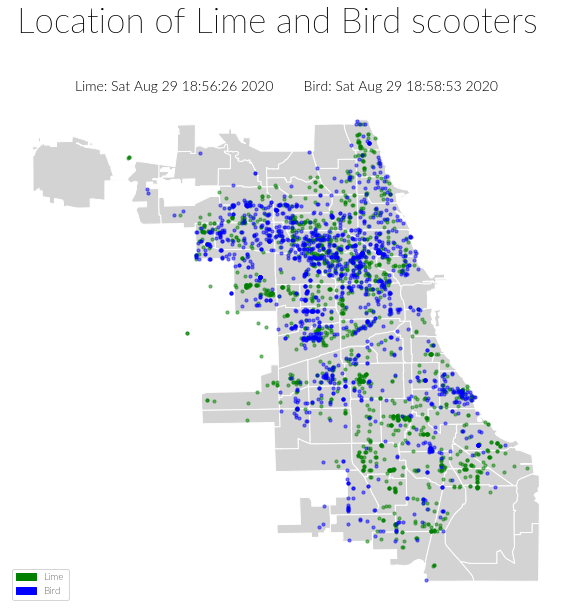

In [15]:
# Test plotting function
fig, test_ax = plt.subplots(1, figsize=(10, 10))
plot_scooters(df_dict, test_ax)

In [16]:
# Make sure that list of JSON objects is sorted by time
# DO NOT RUN YET

'''
sort_by_time(snapshots)

for snapshot in snapshots:
    time = snapshot['last_updated']
    
    # Ignore any snapshots that don't have lat/lon data
    if 'bikes' in snapshot['data'].keys():
        df = pd.DataFrame(snapshot['data']['bikes'])
        plot_scooters(df, 'lon', 'lat', 'lime', time)
        
print("Check folder for images")
'''

'\nsort_by_time(snapshots)\n\nfor snapshot in snapshots:\n    time = snapshot[\'last_updated\']\n    \n    # Ignore any snapshots that don\'t have lat/lon data\n    if \'bikes\' in snapshot[\'data\'].keys():\n        df = pd.DataFrame(snapshot[\'data\'][\'bikes\'])\n        plot_scooters(df, \'lon\', \'lat\', \'lime\', time)\n        \nprint("Check folder for images")\n'